In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image

In [ ]:
from google.colab import files

https://www.kaggle.com/datasets/puneet6060/intel-image-classification

In [ ]:
columns = ['class', 'image']
df = pd.DataFrame(columns = columns)

In [ ]:
classes = {'forest' : 1,
          'mountain' : 3,
          'sea' : 4,}

# classes = {'buildings': 0,
#           'forest' : 1,
#           'glacier' : 2,
#           'mountain' : 3,
#           'sea' : 4,
#           'street' : 5 }

In [ ]:
SIZE = 150
PAD = 250

In [ ]:
def folder_to_df(path, class_type):
  for name in tqdm(os.listdir(path)[:PAD]):
    image = Image.open('/'.join([path, name]))
    
    pixel_values = image.load()
    width, height = image.size
    values = []
    for i in range(height):
      row = []
    
      for j in range(width):
        current_pixel = int(np.mean(pixel_values[j,i])) / 255
        row.append(np.array(current_pixel).astype('float32'))

      values.append(row)

    if width == SIZE and height == SIZE:    
      df.loc[len(df)] = [class_type, np.array([values]).astype('float32')]

In [ ]:
for class_name, class_in_df in classes.items():
  folder_to_df(f'drive/MyDrive/picturesDataset/{class_name}', class_in_df)
df

100%|██████████| 250/250 [01:58<00:00,  2.10it/s]


,class,image
0,1,"[[[0.7647059, 0.42745098, 0.64705884, 0.070588..."
1,1,"[[[0.4862745, 0.43529412, 0.5568628, 0.4039215..."
2,1,"[[[0.043137256, 0.03529412, 0.019607844, 0.011..."
3,1,"[[[0.09411765, 0.101960786, 0.09411765, 0.2235..."
4,1,"[[[0.019607844, 0.0, 0.003921569, 0.019607844,..."
...,...,...
742,4,"[[[0.64705884, 0.64705884, 0.6627451, 0.670588..."
743,4,"[[[0.40392157, 0.41568628, 0.43137255, 0.45098..."
744,4,"[[[0.72156864, 0.7254902, 0.7254902, 0.7294118..."
745,4,"[[[0.7294118, 0.73333335, 0.7372549, 0.7490196..."


In [ ]:
df['class'] = df['class'].replace(1,0)
df['class'] = df['class'].replace(3,1)
df['class'] = df['class'].replace(4,2)
# 1 -> 0, 3 -> 1, 4 -> 2

In [ ]:
data = df['image']
print(f'Before: {data[0].shape}')
data = [np.array(i[:,:,:,np.newaxis][0]).astype('float32') for i in data]
print(f'After: {data[0].shape}')
df['image'] = data

Before: (1, 150, 150)
After: (150, 150, 1)


In [ ]:
train_df, test_df = train_test_split(df, 
                                    test_size=0.2, 
                                    random_state=42,
                                    stratify = df['class'])
train_df.shape

(597, 2)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

train_vars = []
valid_vars = []

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
indexes = sss.split(train_df, train_df['class'])

for train_index, val_index in indexes:
  train_vars.append(train_index)
  valid_vars.append(val_index)

In [ ]:
train = train_df.iloc[train_vars[0]] 
train

,class,image
109,0,"[[[0.07058824], [0.09411765], [0.07450981], [0..."
608,2,"[[[0.57254905], [0.5686275], [0.5686275], [0.5..."
4,0,"[[[0.019607844], [0.0], [0.003921569], [0.0196..."
589,2,"[[[0.56078434], [0.5803922], [0.5529412], [0.5..."
175,0,"[[[0.1254902], [0.08627451], [0.050980393], [0..."
...,...,...
371,1,"[[[0.90588236], [0.90588236], [0.90588236], [0..."
679,2,"[[[0.827451], [0.827451], [0.8235294], [0.8235..."
537,2,"[[[0.7372549], [0.7294118], [0.7137255], [0.71..."
323,1,"[[[0.8666667], [0.8666667], [0.8666667], [0.87..."


In [ ]:
def make_classify_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(16, (2,2), input_shape=(SIZE,SIZE,1), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(.2))
    model.add(layers.Conv2D(8, (2,2), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(3, activation = 'softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

    return model

In [ ]:
make_classify_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 149, 149, 16)      80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 8)         520       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 8)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 8)         0

In [ ]:
EPOCHS = 10
BATCH = 16

In [ ]:
from IPython import display

In [ ]:
validation_history = []
accuracy_history = []
final_validation_res = []

for i, (train_id, val_id) in enumerate(zip(train_vars, valid_vars)):
  print(f'training model № {i}')
  train_x = np.array(train_df.iloc[train_id]['image'].tolist())
  train_y = np.array(train_df.iloc[train_id]['class']).astype('int32')

  val_x = np.array(train_df.iloc[val_id]['image'].tolist())
  val_y = np.array(train_df.iloc[val_id]['class']).astype('int32')

  model = make_classify_model() # creating new model each iteration
  history = model.fit(train_x, train_y, epochs=EPOCHS, batch_size=BATCH, 
                        validation_data = [val_x, val_y])

  display.clear_output(wait=True)

  validation_history.append(history.history['val_loss'])
  accuracy_history.append(history.history['val_accuracy'])
  final_validation_res.append(history.history['val_loss'][-1])

training model № 4
Epoch 1/10
30/30 [==============================] - 9s 274ms/step - loss: 1.1043 - accuracy: 0.4528 - val_loss: 0.9788 - val_accuracy: 0.5333
Epoch 2/10
30/30 [==============================] - 6s 198ms/step - loss: 0.6958 - accuracy: 0.7065 - val_loss: 0.7293 - val_accuracy: 0.6333
Epoch 3/10
30/30 [==============================] - 6s 195ms/step - loss: 0.6197 - accuracy: 0.7254 - val_loss: 0.7125 - val_accuracy: 0.6250
Epoch 4/10
30/30 [==============================] - 6s 197ms/step - loss: 0.5222 - accuracy: 0.7757 - val_loss: 0.7129 - val_accuracy: 0.6750
Epoch 5/10
30/30 [==============================] - 6s 198ms/step - loss: 0.5094 - accuracy: 0.7589 - val_loss: 0.6783 - val_accuracy: 0.6750
Epoch 6/10
30/30 [==============================] - 6s 200ms/step - loss: 0.4648 - accuracy: 0.7987 - val_loss: 0.7114 - val_accuracy: 0.6167
Epoch 7/10
30/30 [==============================] - 6s 195ms/step - loss: 0.4294 - accuracy: 0.8113 - val_loss: 0.6010 - val_accu

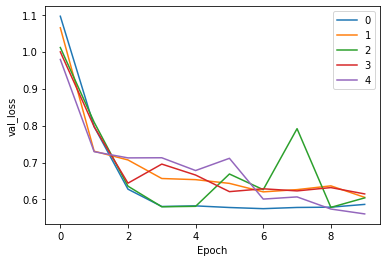

In [ ]:
for i, loss in enumerate(validation_history):
  plt.plot(loss, label=i)
plt.xlabel('Epoch')
plt.ylabel('val_loss')
plt.legend(loc='upper right')
plt.show()

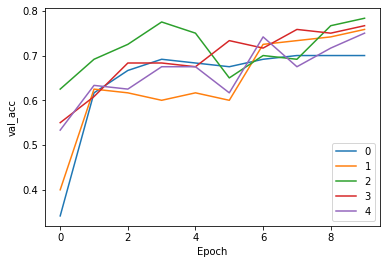

In [ ]:
for i, acc in enumerate(accuracy_history):
  plt.plot(acc, label=i)
plt.xlabel('Epoch')
plt.ylabel('val_acc')
plt.legend(loc='lower right')
plt.show()

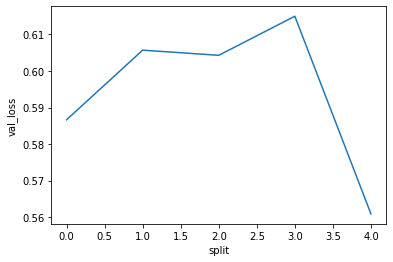

In [ ]:
plt.plot(final_validation_res)
plt.xlabel('split')
plt.ylabel('val_loss')
plt.show()

In [ ]:
min_loss = 10
min_epoch = -1
for epoch in range(EPOCHS):
  epoch_loss = np.mean([i[epoch] for i in validation_history])
  if epoch_loss < min_loss:
    min_epoch = epoch
    min_loss = epoch_loss

print(f'Minimal mean loss: {min_loss} at epoch {min_epoch}')

Minimal mean loss: 0.5945103287696838 at epoch 9


In [ ]:
print(f'theoretical prediction on final model = {np.mean([i[9] for i in accuracy_history])}')

theoretical prediction on final model = 0.7516666650772095


In [ ]:
train_x = np.array(train_df['image'].tolist())
train_y = np.array(train_df['class'].tolist()).astype('int32')
final_model = make_classify_model()
final_model.fit(train_x, train_y, epochs = min_epoch, batch_size = BATCH)

Epoch 1/9
38/38 [==============================] - 8s 181ms/step - loss: 0.9851 - accuracy: 0.5360
Epoch 2/9
38/38 [==============================] - 7s 179ms/step - loss: 0.5945 - accuracy: 0.7119
Epoch 3/9
38/38 [==============================] - 7s 177ms/step - loss: 0.5368 - accuracy: 0.7538
Epoch 4/9
38/38 [==============================] - 7s 179ms/step - loss: 0.4867 - accuracy: 0.7705
Epoch 5/9
38/38 [==============================] - 7s 178ms/step - loss: 0.4814 - accuracy: 0.7739
Epoch 6/9
38/38 [==============================] - 7s 177ms/step - loss: 0.4304 - accuracy: 0.8157
Epoch 7/9
38/38 [==============================] - 7s 178ms/step - loss: 0.4235 - accuracy: 0.8174
Epoch 8/9
38/38 [==============================] - 7s 176ms/step - loss: 0.4589 - accuracy: 0.7739
Epoch 9/9
38/38 [==============================] - 7s 179ms/step - loss: 0.3423 - accuracy: 0.8727


In [ ]:
test_x = np.array(test_df['image'].tolist())
test_y = np.array(test_df['class'].tolist()).astype('int32')

In [ ]:
pred_y = final_model.predict(test_x, verbose=1)
for i, el in enumerate(pred_y):
    pred_y[i] = np.argmax(el)
pred_y = pred_y[:,0]

5/5 [==============================] - 1s 101ms/step


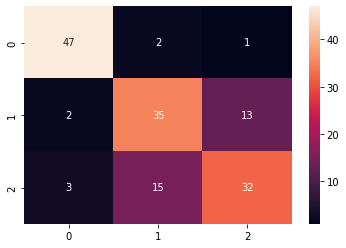

In [ ]:
sns.heatmap(confusion_matrix(test_y, pred_y), annot=True)

In [ ]:
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92        50
           1       0.67      0.70      0.69        50
           2       0.70      0.64      0.67        50

    accuracy                           0.76       150
   macro avg       0.76      0.76      0.76       150
weighted avg       0.76      0.76      0.76       150



## CNNs are a bit chaotic

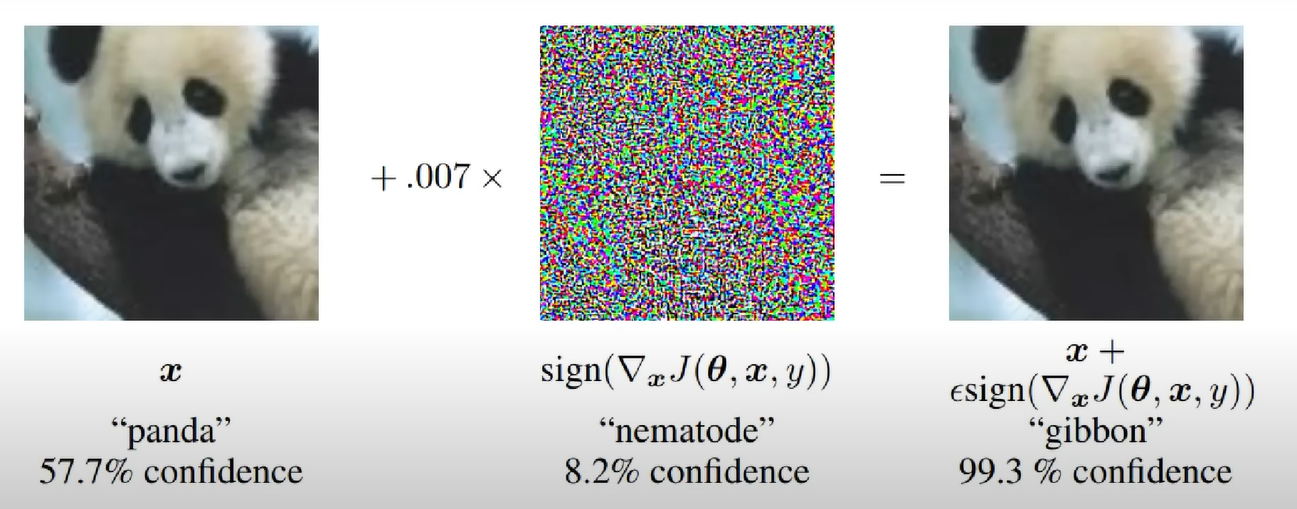